<a href="https://colab.research.google.com/github/kaifoerster/ML_Lab_1_Group-A/blob/main/Lab_Session_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Lab Session 9: fine-tuning Generative LLMs

📅 _Based on Hugging Face Notebook and Data Science Summer School 2023, 22.08.2023_

👨‍🏫 All credits to [Steven Liu](https://huggingface.co/stevhliu) & the Hugging Face community.

##Activate a GPU running time and install packages
In order to run this notebook on a GPU, click on "Runtime" > "Change runtime type" > select "GPU" in the menu bar in to top left. Training a Transformer is much faster on a GPU. Given Colabs's usage limits for GPUs, it is advisable to first test your non-training code on a CPU and only use the GPU once you know that everything is working.

In [ ]:
# Transformers installation
!pip install transformers==4.23 datasets evaluate rouge_score accelerate

In [ ]:
# info on the GPU you are using
!nvidia-smi
# info on available ram
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('\n\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Sun Nov 12 14:56:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generative tasks
Text generation is an important component to many NLP tasks, such as open-ended text generation, summarization, translation and mixed-modality applications such as speech-to-text and vision-to-text translation. For this tutorial, we will focus on summarization.


Summarization creates a shorter version of a document or an article that captures all the important information. It can be formulated as a sequence-to-sequence task and be:

- Extractive: extract the most relevant information from a document.
- Abstractive: generate new text that captures the most relevant information.

This guide will show you how to:

1. Finetune [T5](https://huggingface.co/t5-small) on the California state bill subset of the [BillSum](https://huggingface.co/datasets/billsum) dataset for abstractive summarization.
2. Use your finetuned model for inference.

The task illustrated in this tutorial is supported by the following model architectures:

[BART](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/bart), [BigBird-Pegasus](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/bigbird_pegasus), [Blenderbot](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/blenderbot), [BlenderbotSmall](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/blenderbot-small), [Encoder decoder](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/encoder-decoder), [FairSeq Machine-Translation](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/fsmt), [GPTSAN-japanese](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/gptsan-japanese), [LED](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/led), [LongT5](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/longt5), [M2M100](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/m2m_100), [Marian](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/marian), [mBART](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mbart), [MT5](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mt5), [MVP](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mvp), [NLLB](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/nllb), [NLLB-MOE](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/nllb-moe), [Pegasus](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/pegasus), [PEGASUS-X](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/pegasus_x), [PLBart](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/plbart), [ProphetNet](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/prophetnet), [SwitchTransformers](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/switch_transformers), [T5](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/t5), [XLM-ProphetNet](https://huggingface.co/docs/transformers/main/en/tasks/../##model_doc/xlm-prophetnet)


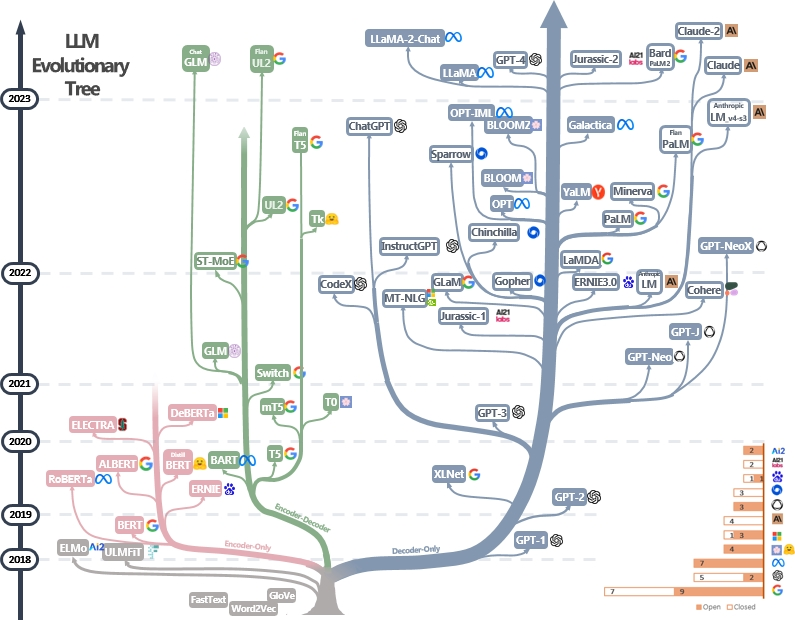

In [ ]:
import requests
from IPython.display import display
from PIL import Image as PILImage
from io import BytesIO

# source: https://github.com/Mooler0410/LLMsPracticalGuide/tree/main
image_url = 'https://github.com/Mooler0410/LLMsPracticalGuide/blob/main/imgs/tree.jpg?raw=true'
response = requests.get(image_url)
img = PILImage.open(BytesIO(response.content))

display(img)

## Load BillSum dataset

Start by loading the smaller California state bill subset of the BillSum dataset from the 🤗 Datasets library:

In [ ]:
from datasets import load_dataset

billsum = load_dataset("billsum", split="ca_test")

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

Split the dataset into a train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method:

In [ ]:
billsum = billsum.train_test_split(test_size=0.2)

Then take a look at an example:

In [ ]:
billsum["train"][0]

There are two fields that you'll want to use:

- `text`: the text of the bill which'll be the input to the model.
- `summary`: a condensed version of `text` which'll be the model target.

## Preprocess

The next step is to load a T5 tokenizer to process `text` and `summary`:

In [ ]:
from transformers import AutoTokenizer

checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so T5 knows this is a summarization task. Some models capable of multiple NLP tasks require prompting for specific tasks.
2. Use the keyword `text_target` argument when tokenizing labels.
3. Truncate sequences to be no longer than the maximum length set by the `max_length` parameter.

In [ ]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) method. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:

In [ ]:
tokenized_billsum = billsum.map(preprocess_function, batched=True)

Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load a evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [ROUGE](https://huggingface.co/spaces/evaluate-metric/rouge) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the ROUGE metric:

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

Your `compute_metrics` function is ready to go now, and you'll return to it when you setup your training.

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load T5 with [AutoModelForSeq2SeqLM](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSeq2SeqLM):

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

At this point, only three steps remain:

1. Define your training hyperparameters in [Seq2SeqTrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments). The only required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the ROUGE metric and save the training checkpoint.
2. Pass the training arguments to [Seq2SeqTrainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Seq2SeqTrainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    #per_device_train_batch_size=16,
    #per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    #push_to_hub=True,
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_billsum["train"],
    eval_dataset=tokenized_billsum["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text, summary. If title, text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 989
  Num Epochs = 4
  Instan

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,2.660720,0.127200,0.042100,0.107700,0.107900,19.000000
2,No log,2.540961,0.144300,0.053900,0.120500,0.120500,19.000000
3,No log,2.495131,0.170400,0.072500,0.142300,0.142600,19.000000
4,No log,2.483067,0.175100,0.077400,0.146800,0.147000,19.000000


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text, summary. If title, text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 248
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text, summary. If title, text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 248
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, text, summary. If title, text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Runn

TrainOutput(global_step=496, training_loss=2.7999129756804435, metrics={'train_runtime': 297.9889, 'train_samples_per_second': 13.276, 'train_steps_per_second': 1.664, 'total_flos': 1070824333246464.0, 'train_loss': 2.7999129756804435, 'epoch': 4.0})

<Tip>

For a more in-depth example of how to finetune a model for summarization, take a look at the corresponding
[notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/summarization.ipynb).

</Tip>

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Come up with some text you'd like to summarize. For T5, you need to prefix your input depending on the task you're working on. For summarization you should prefix your input as shown below:

In [ ]:
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a `pipeline` for summarization with your model, and pass your text to it:

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="stevhliu/my_awesome_billsum_model")
summarizer(text)

RuntimeError: ignored

You can also manually replicate the results of the `pipeline` if you'd like:


Tokenize the text and return the `input_ids` as PyTorch tensors:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("stevhliu/my_awesome_billsum_model")
inputs = tokenizer(text, return_tensors="pt").input_ids

Use the [generate()](https://huggingface.co/docs/transformers/main/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to create the summarization. For more details about the different text generation strategies and parameters for controlling generation, check out the [Text Generation](https://huggingface.co/docs/transformers/main/en/tasks/../main_classes/text_generation) API.

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("stevhliu/my_awesome_billsum_model")
outputs = model.generate(inputs, max_new_tokens=100, do_sample=False)

Decode the generated token ids back into text:

In [ ]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

'the inflation reduction act lowers prescription drug costs, health care costs, and energy costs. it's the most aggressive action on tackling the climate crisis in american history. it will ask the ultra-wealthy and corporations to pay their fair share.'

# More resources



In [ ]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/yHnr5Dk2zCI?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')